In [2]:
# import things
import math
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import numpy as np
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)

train_path = './data/train.csv'
test_path = './data/test.csv'

In [3]:
class eda_data:
    def __init__(self, path):
        self.data = pd.read_csv(path)
        self.corrmat = self.data.corr()
        self.missing_data = self.get_missing()
    
    def concat_data(self, col_name):
        return pd.concat([self.data['SalePrice'], self.data[col_name]], axis=1)
    
    def scatter_plot(self, col_name):
        data = self.concat_data(col_name)
        data.plot.scatter(x=col_name, y='SalePrice', ylim=(0, 800000))
    
    def scatter_mul_plot(self, col_lst):
        sns.set()
        sns.pairplot(self.data[col_lst], size = 2.5)
        plt.show()
    
    def box_plot(self, col_name):
        data = self.concat_data(col_name)
        f, ax = plt.subplots(figsize=(16, 8))
        fig = sns.boxplot(x=col_name, y="SalePrice", data=data)
        fig.axis(ymin=0, ymax=800000);
    
    def correlation_matrix(self):
        k = 10 #number of variables for heatmap
        cols = self.corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
        cm = np.corrcoef(self.data[cols].values.T)
        sns.set(font_scale=1.25)
        hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
        plt.show()
        
    def get_missing(self):
        total = self.data.isnull().sum().sort_values(ascending=False)
        percent = (self.data.isnull().sum() / self.data.isnull().count()).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        return missing_data
        
    def check_nan(self, col_lst):
#         eda_df.data[['SalePrice']].isnull().values.any()
        for item in col_lst:
            if self.data[[item]].isnull().values.any():
                print(f"column: {item} has NaN data.")
            else:
                print(f"column: {item} is fine.")

In [4]:
class create_data:
    def __init__(self, path):
        self.data = pd.read_csv(path)
        self.missing_data = self.get_missing()
        
    def get_missing(self):
        total = self.data.isnull().sum().sort_values(ascending=False)
        percent = (self.data.isnull().sum() / self.data.isnull().count()).sort_values(ascending=False)
        missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
        return missing_data
        
    def chose_model(self, model, using_col, cat_col, is_test=False):
        if model == 1:
            self.model_df = self.drop_nan_data(self.missing_data)
        elif model == 2:
            self.model_df = self.deal_nan_data()
        elif model == 3:
            self.model_df = self.deal_ol_data()
        else:
            self.model_df = self.handle()
            print('not build yet.')
        
        # Id for combine two dataframe  
        id_lst = self.model_df['Id']
        # deal with SalePrice
        if not is_test:
            house_price = self.model_df['SalePrice']
    #       house_price = np.log(house_price)
            house_price /= 1000
        # scaler value
        tmp1_df = self.model_df[using_col]
        tmp1_df = (tmp1_df - tmp1_df.mean()) / tmp1_df.std()
        if not is_test:
            tmp1_df['SalePrice'] = house_price
        tmp1_df['Id'] = id_lst
        # category value
        tmp2_df = self.model_df[cat_col]
        # merge scaler value df & category value df
        self.model_df = pd.merge(tmp1_df, tmp2_df, on='Id')
        self.model_df = self.model_df.drop(['Id'], axis=1)
        # one-hot encode
        self.model_df = self.dum_data(self.model_df)
        
    def drop_nan_data(self, missing_df):
        drop_data = self.data.copy()
        drop_data = drop_data.drop((missing_df[missing_df['Total'] > 1]).index, 1)
        drop_data = drop_data.drop(drop_data.loc[drop_data['Electrical'].isnull()].index)
        self.drop_data = drop_data
        return drop_data
    
    def deal_nan_data(self):
        fill_data = self.data.copy()
        fill_data['BsmtQual'] = fill_data['BsmtQual'].apply(lambda x: 'NOVAL' if x != x else x)
        self.fill_data = fill_data
        return fill_data
        
    def deal_ol_data(self):
        ol_data = self.data.copy()
        ol_data['1stFlrSF'] = ol_data['1stFlrSF'].apply(lambda x: min(x, 2500))
        ol_data['GrLivArea'] = ol_data['GrLivArea'].apply(lambda x: min(x, 3000))
        ol_data['TotalBsmtSF'] = ol_data['TotalBsmtSF'].apply(lambda x: min(x, 3000))
        self.ol_data = ol_data
        return ol_data
    
    def dum_data(self, data_df):
        return pd.get_dummies(data_df)
#     def out_liars(self):
    
class create_model:
    def __init__(
        self,
        train_df,
        label_col='SalePrice',
        learning_rate=0.02,
        steps=100,
        batch_size=10,
        periods=10,
        hidden_units=[8, 4],
        load_model=False,
        load_model_name='default',
        save_model=False,
        save_model_name='default',
    ):
        self.label = label_col
        # learning rate: optimizer
        self.learning_rate = learning_rate
        # steps, batch_size, periods: train
        self.steps = steps
        self.batch_size = batch_size
        self.periods = periods
        self.h_units = hidden_units
        # save model
        self.save_model = save_model
        self.load_model = load_model
        self.save_model_name = save_model_name
        self.load_model_name = load_model_name
        self.save_model_path = './model/' + self.save_model_name
        self.load_model_path = './model/' + self.load_model_name
        # split data
        self.te, self.tt, self.ve, self.vt = self.get_split_data(train_df)
        
        # create lenearRegressor
        self.feature_cols = self.get_feature_cols(train_df)
        self.optimizer = self.get_optimizer(learning_rate)
        
        if self.load_model:
            if self.save_model:
                self.lr = tf.estimator.DNNRegressor(
                    hidden_units=self.h_units,
    #             self.lr = tf.estimator.LinearRegressor(
                    feature_columns=self.feature_cols,
                    optimizer=self.optimizer,
                    model_dir=self.save_model_path,
                    warm_start_from=self.load_model_path
                )
            else:
                self.lr = tf.estimator.DNNRegressor(
                    hidden_units=self.h_units,
    #             self.lr = tf.estimator.LinearRegressor(
                    feature_columns=self.feature_cols,
                    optimizer=self.optimizer,
                    warm_start_from=self.load_model_path
                )
        else:
            if self.save_model:
                self.lr = tf.estimator.DNNRegressor(
                    hidden_units=self.h_units,
                #             self.lr = tf.estimator.LinearRegressor(
                    feature_columns=self.feature_cols,
                    optimizer=self.optimizer,
                    model_dir=self.save_model_path
                ) 
            else:
                self.lr = tf.estimator.DNNRegressor(
                    hidden_units=[20, 10, 5],
    #             self.lr = tf.estimator.LinearRegressor(
                    feature_columns=self.feature_cols,
                    optimizer=self.optimizer
                )
        print('build the model')
    
    def get_split_data(self, train_df):
        # sample 80% for train data, 20% for vali data
        train_set, vali_set = self.split_train(train_df, 0.8)
        te, tt = self.get_e_t(train_set)
        ve, vt = self.get_e_t(vali_set)
        return te, tt, ve, vt
        
    def split_train(self, data_df, per):
        t_s = data_df.sample(frac=per, replace=False, random_state=42)
        v_s = data_df.loc[ set(data_df.index) - set(t_s.index)]
        return t_s, v_s
    
    def get_e_t(self, data_df):
        # data examples
        d_e = data_df.copy().drop(self.label, axis=1)
        # data targets
        d_t = pd.DataFrame()
        d_t[self.label] = data_df[self.label]
        return d_e, d_t
    
    def get_feature_cols(self, train_df):
        feature_df = train_df.copy().drop(self.label, axis=1)
        tmp_feature = [tf.feature_column.numeric_column(my_feature) for my_feature in feature_df]
#         if bin_age: # boolean:
#             tmp_age = tf.feature_column.numeric_column("Age")
#             bucketized_age = tf.feature_column.bucketized_column(
#               tmp_age, boundaries=get_quantile_based_boundaries(
#                 input_features["Age"], 4))
#             tmp_feature += [bucketized_age]
        return set(tmp_feature)
    
    def get_optimizer(self, learning_rate):
#         change the optimizer!!!!!!
        my_opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
#         my_opt = tf.train.AdamOptimizer(learning_rate=learning_rate)
        my_opt = tf.contrib.estimator.clip_gradients_by_norm(my_opt, 2.0)
        return my_opt
    
    def my_input_fn(
        self,
        features,
        targets,
        batch_size=1,
        shuffle=True,
        num_epochs=None
    ):
        # Convert pandas data into a dict of np arrays.
        features = {key:np.array(value) for key,value in dict(features).items()}
        # Construct a dataset, and configure batching/repeating.
        ds = Dataset.from_tensor_slices((features,targets)) # warning: 2GB limit
        ds = ds.batch(batch_size).repeat(num_epochs)
        # Shuffle the data, if specified.
        if shuffle:
            ds = ds.shuffle(10000)
        # Return the next batch of data.
        features, labels = ds.make_one_shot_iterator().get_next()
        return features, labels
    
    def train(self):
        steps_per_period = self.steps / self.periods
        # create input function
        training_input_fn = lambda: self.my_input_fn(self.te, self.tt[self.label], batch_size=self.batch_size)
        predict_training_input_fn = lambda: self.my_input_fn(self.te, self.tt[self.label], num_epochs=1, shuffle=False)
        predict_vali_input_fn = lambda: self.my_input_fn(self.ve, self.vt[self.label], num_epochs=1, shuffle=False)
        
        print('Training model...')
        # recording RMSE
        training_rmse = []
        validation_rmse = []
        for period in range(self.periods):
            self.lr.train(
                input_fn=training_input_fn,
                steps=steps_per_period
            )
            
            # compute training predictions
            training_predictions = self.lr.predict(input_fn=predict_training_input_fn)
            training_predictions = np.array([item['predictions'][0] for item in training_predictions])
            # compute validation predictions
            validation_predictions = self.lr.predict(input_fn=predict_vali_input_fn)
            validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
            # get validation eval
            training_eval = self.lr.evaluate(input_fn=predict_training_input_fn)
            validation_eval = self.lr.evaluate(input_fn=predict_vali_input_fn)
            print("training_eval: {}".format(training_eval['average_loss']))
            print("validation_eval: {}".format(validation_eval['average_loss']))

            # compute training loss
            training_root_mean_squared_error = math.sqrt(
                metrics.mean_squared_error(training_predictions, self.tt))
            # compute validation loss
            validation_root_mean_squared_error = math.sqrt(
                metrics.mean_squared_error(validation_predictions, self.vt))
            # Occasionally print the current loss.
            print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
            # Add the loss metrics from this period to our list.
            training_rmse.append(training_root_mean_squared_error)
            validation_rmse.append(validation_root_mean_squared_error)
        
        print("Model training finished.")
        # saving model
        if self.save_model:
            print("Saving model...")
            
        # output a graph of loss metrics over periods.
        self.result_plot(training_rmse, validation_rmse)
        
    def result_plot(self, t_rmse, v_rmse):
        plt.ylabel("RMSE")
        plt.xlabel("Periods")
        plt.title("Root Mean Squared Error vs. Periods")
        plt.tight_layout()
        plt.plot(t_rmse, label="training")
        plt.plot(v_rmse, label="validation")
        plt.legend()
        

class predict_file:
    def __init__(self, model, test_df, id_frame):
        self.test_df = test_df
        self.id_frame = id_frame
#         self.predict_col = predict_col
        self.predict_input_fn = self.create_predict_fn()
        
        self.predictions = list(model.lr.predict(input_fn=self.predict_input_fn))
        self.predictions = np.array([item['predictions'][0] for item in self.predictions])
        self.predictions *= 1000
        
        self.evaluation = self.id_frame#test_df['Id'].copy().to_frame()
        self.evaluation['SalePrice'] = self.predictions
    
    def create_predict_fn(self):
#         predict_df = self.test_df
        predict_input_fn = tf.estimator.inputs.pandas_input_fn(
            x=self.test_df,
            num_epochs=1,
            shuffle=False
        )
        return predict_input_fn
    
    def save_predict(self, path):
        self.evaluation.to_csv(path, index=False)

In [5]:
# mode l: just drop NaN data

# using_col = ['SalePrice', 'OverallQual', 'TotalBsmtSF', YearBuilt']
m1_using_col = ['Id', 'SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'FullBath']
m1_category_col = ['Id', 'SaleType', 'SaleCondition']
# predict_col = using_col[1:]

# loading csv file
train_df = create_data(train_path)
# test_df = create_data(test_path)

# drop NaN data
train_df.chose_model(1, m1_using_col, m1_category_col)
train_df.model_df.head()

# create model
# model = create_model(
#     train_df=train_df.model_df, 
#     save_model=True, 
#     save_model_name="model1_v1",
#     load_model=True, 
#     load_model_name="model1_v1",
#     learning_rate=0.05,
#     steps=200,
#     batch_size=15
# #     hidden_units=[3]
# )

# # training model
# model.train()

,SalePrice,OverallQual,GrLivArea,TotalBsmtSF,FullBath,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,208.5,0.650629,0.369928,-0.460412,0.789909,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1,181.5,-0.072347,-0.482349,0.465470,0.789909,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
2,223.5,0.650629,0.514511,-0.314460,0.789909,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
3,140.0,0.650629,0.383245,-0.688461,-1.025016,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0
4,250.0,1.373606,1.298301,0.198652,0.789909,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0


build the model
Training model...
training_eval: 33015.5
validation_eval: 31342.74609375
  period 00 : 181.70
training_eval: 6829.04736328125
validation_eval: 5697.140625
  period 01 : 82.64
training_eval: 2250.09912109375
validation_eval: 1678.9881591796875
  period 02 : 47.44
training_eval: 1950.187744140625
validation_eval: 1371.362548828125
  period 03 : 44.16
training_eval: 1694.54150390625
validation_eval: 1030.68115234375
  period 04 : 41.16
training_eval: 1610.4620361328125
validation_eval: 860.8313598632812
  period 05 : 40.13
training_eval: 1608.81591796875
validation_eval: 1019.7714233398438
  period 06 : 40.11
training_eval: 1535.3905029296875
validation_eval: 876.1521606445312
  period 07 : 39.18
training_eval: 1511.1719970703125
validation_eval: 854.7921752929688
  period 08 : 38.87
training_eval: 1862.1815185546875
validation_eval: 1158.21337890625
  period 09 : 43.15
Model training finished.
Saving model...


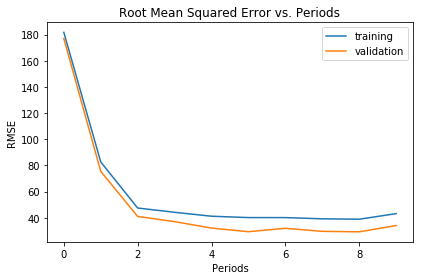

build the model
Training model...
training_eval: 34591.24609375
validation_eval: 32956.4453125
  period 00 : 185.99
training_eval: 15368.943359375
validation_eval: 13933.693359375
  period 01 : 123.97
training_eval: 2595.337158203125
validation_eval: 2222.002685546875
  period 02 : 50.94
training_eval: 2182.99755859375
validation_eval: 1737.825927734375
  period 03 : 46.72
training_eval: 1792.3421630859375
validation_eval: 1425.1376953125
  period 04 : 42.34
training_eval: 1679.6519775390625
validation_eval: 1358.721923828125
  period 05 : 40.98
training_eval: 1630.9033203125
validation_eval: 1218.7078857421875
  period 06 : 40.38
training_eval: 1601.4154052734375
validation_eval: 1215.740234375
  period 07 : 40.02
training_eval: 1589.247802734375
validation_eval: 1202.8211669921875
  period 08 : 39.87
training_eval: 1611.680908203125
validation_eval: 1183.1939697265625
  period 09 : 40.15
Model training finished.
Saving model...


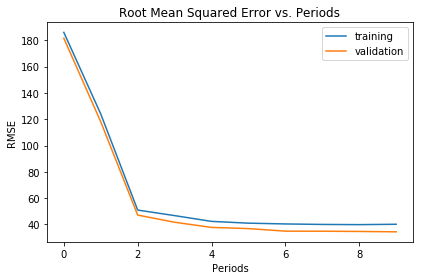

In [35]:
# model 3: deal with NaN data & out lier data
# using_col = ['SalePrice', 'OverallQual', 'TotalBsmtSF', YearBuilt']
m3_using_col = ['Id', 'SalePrice', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'FullBath', '1stFlrSF']
m3_category_col = ['Id', 'SaleType', 'SaleCondition']
# predict_col = using_col[1:]

# loading csv file
train_df = create_data(train_path)

# deal out lier data
train_df.chose_model(3, m3_using_col, m3_category_col)
train_df.model_df.head()

# create model
model3 = create_model(
    train_df=train_df.model_df, 
    save_model=True, 
    save_model_name="model3_test_v0",
#     load_model=True, 
#     load_model_name="model1_test_v7",
    learning_rate=0.08,
    steps=200,
    batch_size=15,
#     hidden_units=[3]
)

# training model
model3.train()


# data = pd.concat([t_df.data['SalePrice'], t_df.data['GrLivArea']], axis=1)
# data.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0, 800000))

# data2 = pd.concat([t_df.ol_data['SalePrice'], t_df.ol_data['GrLivArea']], axis=1)
# data2.plot.scatter(x='GrLivArea', y='SalePrice', ylim=(0, 800000))

In [34]:
test_df = create_data(test_path)
m1_using_col = ['Id', 'OverallQual', 'GrLivArea', 'TotalBsmtSF', 'FullBath']
m1_category_col = ['Id', 'SaleType', 'SaleCondition']
test_df.chose_model(1, m1_using_col, m1_category_col, True)
id_frame = test_df.data['Id'].copy().to_frame()

predict = predict_file(model, test_df.model_df, id_frame)
# predict.evaluation.head()
predict.save_predict('m1_predict.csv')